In [15]:
import numpy as nm
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [16]:
def I(D): # IDF function
    return k1*(D**b1+k2)**(-1*b2)
def AA(x1,x2): # Hillslope area function for upslope x1 and downslope x2
    return c/a*(nm.exp(a*x2)-nm.exp(a*x1))
def tc(D): # function that returns time of concentration for intensity at duration D
    hmax = ((I(D)-I(D)*nm.exp(a*divide-a*stream))/(a*alpha))**(0.5)
    if a>0:
        return (1./(abs(a)*alpha*I(D))**(0.5))*nm.arctan(hmax*(abs(a)*alpha/I(D))**(0.5))
        #return (a*alpha/I(D))**(0.5)*nm.arctan(hmax*(a*alpha/I(D))**(0.5))
    else:
        return (1./(abs(a)*alpha*I(D))**(0.5))*nm.arctanh(hmax*(abs(a)*alpha/I(D))**(0.5))
        #return (-a*alpha/I(dcrit))**(0.5)*nm.arctanh(hmax*(-a*alpha/I(dcrit))**(0.5))

In [17]:
# this block conducts the optimization and print "done" when complete

# user-defined parameters
#-------------------------------------

# parameters for IFD curve:
# I = k1/(D^b1+k2)^b2
# b1, b2, k1, k2 >=0
# b1*b2<=1
k1 =  10.0
b2 =  1.
k2 =  0.0
b1 =  .7525

# resolution of plotting data
res = 1000

# set minimum and maximum storm durations for numerical optimization
dmin = 0.01
dmax = 15

# x locations of divide and stream
divide = 0.
stream = 50.

# values of curvature parameter a and constant c from width function
# w(x) = ce^(ax)
avals = nm.linspace(-0.08,0.08,20)
c = 10.

alpha = 0.5 # kinematic roughness


#-------------------------------------

dcritvals = []  # values of D_crit for plotting
tcvals = []     # values of t_c for plotting
areavals = []   # values of contributing area for plotting
tcIvals = []    # values of I at t_c for plotting
dcritIvals = [] # values of I at D_crit for plotting
tcQvals = []    # values of Q at t_c for plotting
dcritQvals = [] # values of Q at D_crit
maxarea = []    # values of hillslope area for plotting

# perform optimization for each value of a
for aval in avals:
    a=aval
    dvals = nm.linspace(dmin,dmax,res)
    Amax = AA(divide,stream) # total hillslope area
    Avals = [] # hillslope area for each duration in dvals
    Ivals = [I(D) for D in dvals] # intensity for each duration in dvals

    # perform the optimization
    # you don't actually need to do this for convergent hillslopes in order to get the info at the bottom since tc=dcrit
    for i in range(len(dvals)):
        D = dvals[i]

        # defines system of two equations that can be solved to find the furthest upslope point contributing to flow at duration D, intensity I
        def equations(p): 
            x0,h = p 
            f1 = x0 - (1./a*nm.log((I(D)-alpha*a*h**2)/I(D))+stream) 
            if a>0:
                f2 = h - (nm.tanh(D*(I(D)*abs(a)*alpha)**(0.5))*(I(D)/(abs(a)*alpha))**(0.5))
            else:
                f2 = h - (nm.tan(D*(I(D)*abs(a)*alpha)**(0.5))*(I(D)/(abs(a)*alpha))**(0.5))
            return (f1,f2) 
        # solves the system of equations
        x0,h = fsolve(equations,(divide,0.1))

        # adds the contributing area to the list of A values, but just adds the maximum area if 
        # the program says that more than the maximum area contributes
        if x0<divide:
            Avals = Avals +[Amax]
        else:
            A = c/a*(nm.exp(a*stream)-nm.exp(a*x0))
            Avals = Avals + [A]

    l=0
    for i in range(len(Avals)):
        if Avals[i]==Amax and l==0:
            l=i
    t_maxA = dvals[l]       


    AtimesI = [] # calculates A*I for each duration in dvals
    dvalsnew = []
    # removes any infinite points from this analysis
    for i in range(len(Ivals)):
        if Ivals[i]*Avals[i]!=nm.inf:
            AtimesI = AtimesI + [Ivals[i]*Avals[i]]
            dvalsnew = dvalsnew + [dvals[i]]
    # finds the maximum value of A*I
    maxq = max(AtimesI)

    # finds the index at which the maximum value occurs
    l=0
    for i in range(len(AtimesI)):
        if AtimesI[i]==maxq and l==0:
            l=i
    # finds the duration associated with the maximum value, i.e. the critical duration
    dcrit = dvals[l]

    if a>0:
        hmax = ((I(dcrit)-I(dcrit)*nm.exp(a*divide-a*stream))/(a*alpha))**(0.5)
        tc_at_crit = (1./(abs(a)*alpha*I(dcrit))**(0.5))*nm.arctan(hmax*(abs(a)*alpha/I(dcrit))**(0.5))
    else:
        hmax = ((I(dcrit)-I(dcrit)*nm.exp(a*divide-a*stream))/(a*alpha))**(0.5)
        tc_at_crit = (1./(abs(a)*alpha*I(dcrit))**(0.5))*nm.arctanh(hmax*(abs(a)*alpha/I(dcrit))**(0.5))


    #prints quantities of interest
    dcritvals = dcritvals + [dcrit]
    tcvals = tcvals + [t_maxA]
    areavals = areavals+[Avals[l]]
    maxarea = maxarea + [Amax]
    tcIvals = tcIvals + [I(t_maxA)]
    dcritIvals = dcritIvals+ [I(dcrit)]
    tcQvals = tcQvals+[I(t_maxA)*Amax]
    dcritQvals = dcritQvals+[I(dcrit)*Avals[l]]
print 'done'

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in arctanh


done


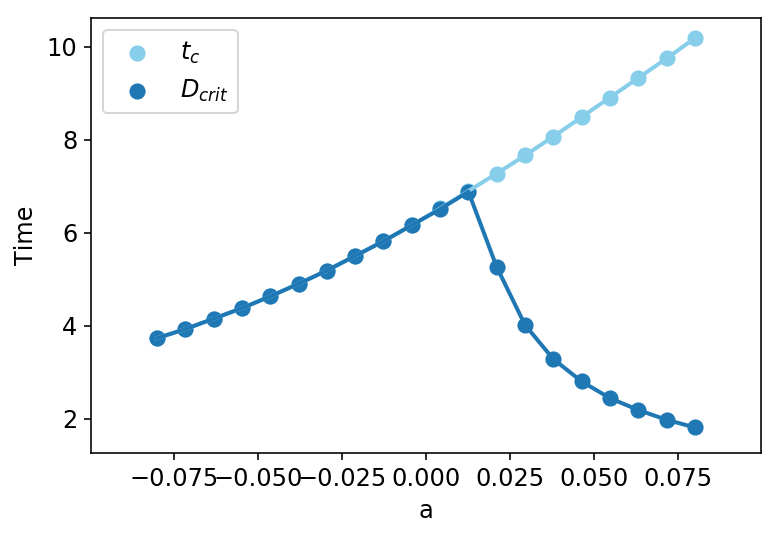

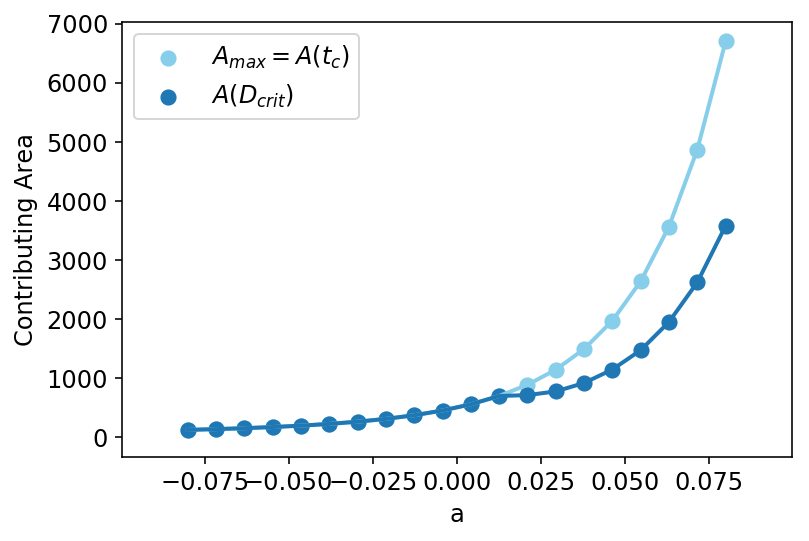

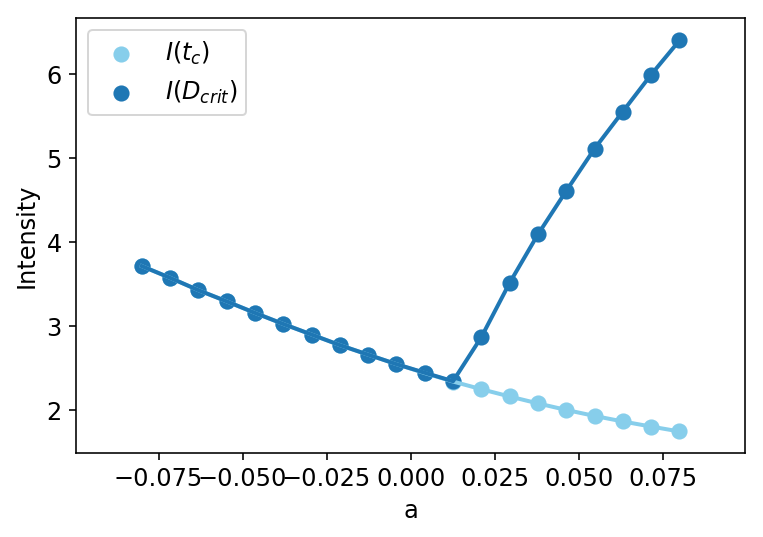

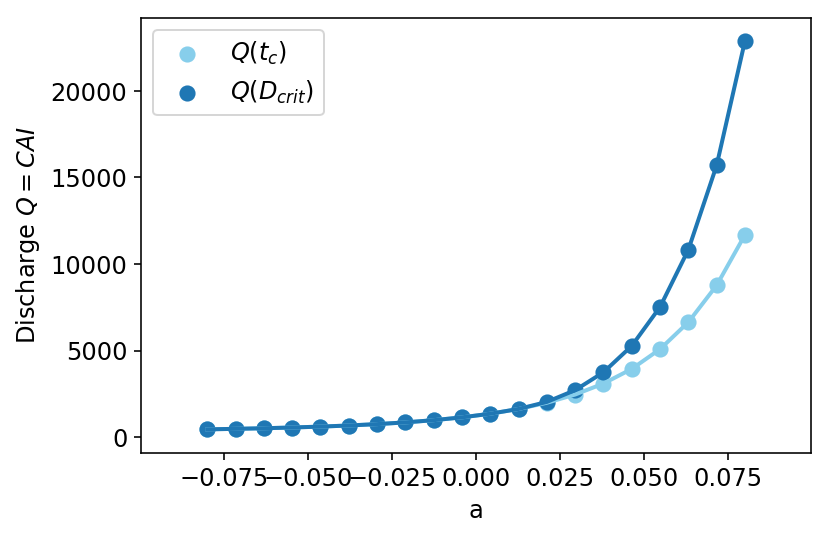

In [23]:
# plots optimization data

%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 12})

xx = 2 # line width for plotting

tc=plt.scatter(avals,tcvals,c='skyblue',s=50)
plt.plot(avals,tcvals,c='skyblue',linewidth = xx)
dc=plt.scatter(avals,dcritvals,s=50)
plt.plot(avals,dcritvals,linewidth = xx)
plt.legend([tc,dc],['$t_c$','$D_{crit}$'])
plt.xlabel('a')
plt.ylabel('Time')
plt.show()

tc=plt.scatter(avals,maxarea,c='skyblue',s=50)
plt.plot(avals,maxarea,c='skyblue',linewidth = xx)
dc=plt.scatter(avals,areavals,s=50)
plt.plot(avals,areavals,linewidth = xx)
plt.xlabel('a')
plt.ylabel('Contributing Area')
plt.legend([tc,dc],['$A_{max}=A(t_c)$','$A(D_{crit})$'])
plt.show()

tc=plt.scatter(avals,tcIvals,c='skyblue',s=50)
plt.plot(avals,tcIvals,c='skyblue',linewidth = xx)
dc=plt.scatter(avals,dcritIvals,s=50)
plt.plot(avals,dcritIvals,linewidth = xx)
plt.xlabel('a')
plt.ylabel('Intensity')
plt.legend([tc,dc],['$I(t_c)$','$I(D_{crit})$'])
plt.show()

tc=plt.scatter(avals,tcQvals,c='skyblue',s=50)
plt.plot(avals,tcQvals,c='skyblue',linewidth = xx)
dc=plt.scatter(avals,dcritQvals,s=50)
plt.plot(avals,dcritQvals,linewidth = xx)
plt.xlabel('a')
plt.ylabel('Discharge $Q=CAI$')
plt.legend([tc,dc],['$Q(t_c)$','$Q(D_{crit})$'])
plt.show()
